In [2]:
import numpy as np
import pandas as pd

1. Load Data

In [3]:
df_resume= pd.read_csv('resume1.csv')

In [4]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]  #optional if your computer is fast, no need

In [5]:
df_resume.shape

(1000, 4)

2. Load skill data

In [7]:
import spacy
nlp = spacy.load('en_core_web_md')
skill_path = "./skills.jsonl"

In [8]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [9]:
doc = nlp("Chaky loves deep learning.")
doc.ents

(Chaky, deep learning)

3. Extracting skills from resume.csv

In [10]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
2311,19671909,MIDDLE SCHOOL PRINCIPAL Execu...,"<div class=""fontsize fontface vmargins hmargin...",ARTS
511,14708590,SERVICE ADVOCATE IV- CLINICAL SUPPORT...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE
1396,10001727,SOUS CHEF Work Experience ...,"<div class=""fontsize fontface vmargins hmargin...",CHEF
1740,35737840,ENGINEERING AIDE Professional...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING
1317,20210676,DIGITAL COMMUNICATIONS SPECIALIST ...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA


In [11]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [12]:
#random sampling
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:200]

'         ADMINISTRATIVE ASSOCIATE II, CONSTRUCTION MANAGEMENT DEPARTMENT       Professional Overview     Committed and motivated Administrative Assistant with exceptional customer service and decision'

In [13]:
preprocessing(random_resume[:200])

'administrative associate ii construction management department professional overview committed motivate administrative assistant exceptional customer service decision'

In [14]:
#let's apply to the whole dataframe
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [15]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
2311,19671909,MIDDLE SCHOOL PRINCIPAL Execu...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,middle school principal executive profile to o...
511,14708590,SERVICE ADVOCATE IV- CLINICAL SUPPORT...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE,service advocate iv- clinical support summary ...
1396,10001727,SOUS CHEF Work Experience ...,"<div class=""fontsize fontface vmargins hmargin...",CHEF,sous chef work experience sous chef jul 2010 c...
1740,35737840,ENGINEERING AIDE Professional...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING,engineering aide professional summary resource...
1317,20210676,DIGITAL COMMUNICATIONS SPECIALIST ...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA,digital communication specialist summary digit...


4. Extract skills

In [16]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    skills = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

In [17]:
df_resume.head(2)

,ID,Resume_str,Resume_html,Category,Clean_resume
2311,19671909,MIDDLE SCHOOL PRINCIPAL Execu...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,middle school principal executive profile to o...
511,14708590,SERVICE ADVOCATE IV- CLINICAL SUPPORT...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE,service advocate iv- clinical support summary ...


In [18]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [19]:
df_resume.Skills.iloc[0]

['ruby',
 'monitoring',
 'framework',
 'data management',
 'component',
 'design',
 'certificate',
 'schedule',
 'support']

5. Lets do visualization

In [20]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [21]:
category = 'HR'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(43, 6)

In [22]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [24]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [25]:
counting

OrderedDict([('business', 34),
             ('support', 27),
             ('database', 22),
             ('schedule', 21),
             ('design', 18),
             ('documentation', 14),
             ('material', 12),
             ('marketing', 11),
             ('software', 11),
             ('business administration', 10)])

<BarContainer object of 10 artists>

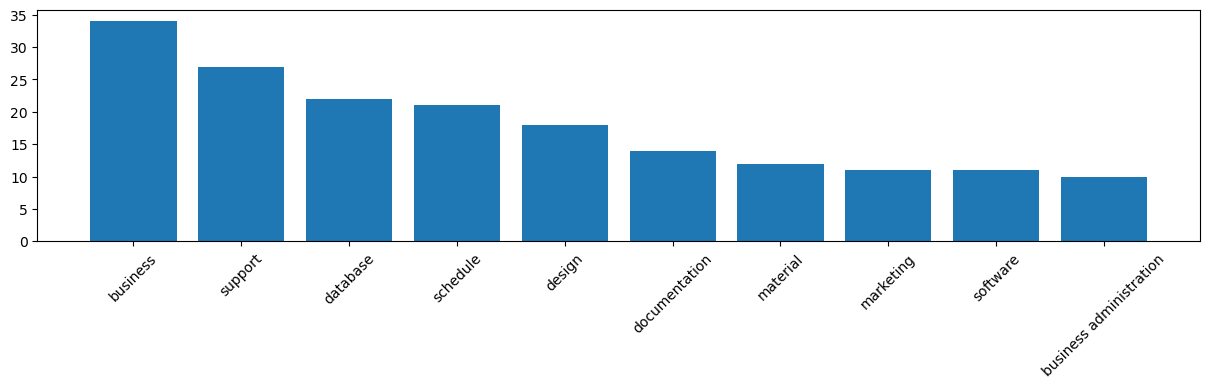

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

6. NER

In [28]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[1]

In [29]:
doc = nlp(text)

In [30]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

7. Lets load PDF

In [32]:
from PyPDF2 import PdfReader
reader=PdfReader("someone_cv.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text() 

In [33]:
text = preprocessing(text)

In [34]:
doc = nlp(text)

In [35]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [36]:
skills = []

for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)
        
print(set(skills))

{'algorithms', 'engineering', 'computer science', 'ai', 'deep learning'}


In [37]:
from PyPDF2 import PdfReader
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_md')
edu_path ="./skills_edu.jsonl"

In [44]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(edu_path)
nlp.pipe_names

ValueError: [E007] 'entity_ruler' already exists in pipeline. Existing names: ['tok2vec', 'tagger', 'parser', 'senter', 'attribute_ruler', 'lemmatizer', 'ner', 'entity_ruler']

In [45]:
# Function to clean the input data.
def preprocessing(sentence):
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []

    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
                token.pos_ != 'SYM':
            cleaned_tokens.append(token.lemma_.lower().strip())

    return " ".join(cleaned_tokens)

In [49]:
def get_education(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    education = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "EDUCATION":
            education.append(ent.text)
    
    return education

In [50]:
df_resume['Education'] = df_resume.Clean_resume.apply(get_education)
df_resume['Education'] = df_resume.Education.apply(unique_skills)

C:\Users\Paramik\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
C:\Users\Paramik\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
C:\Users\Paramik\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
C:\Users\Paramik\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
C:\Users\Paramik\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ru

In [51]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume,Skills,Education
2311,19671909,MIDDLE SCHOOL PRINCIPAL Execu...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,middle school principal executive profile to o...,"[ruby, monitoring, framework, data management,...",[]
511,14708590,SERVICE ADVOCATE IV- CLINICAL SUPPORT...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE,service advocate iv- clinical support summary ...,"[collaboration, documentation, database, proje...",[]
1396,10001727,SOUS CHEF Work Experience ...,"<div class=""fontsize fontface vmargins hmargin...",CHEF,sous chef work experience sous chef jul 2010 c...,"[software, business administration, certificat...",[]
1740,35737840,ENGINEERING AIDE Professional...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING,engineering aide professional summary resource...,"[documentation, component, engineering, design...",[]
1317,20210676,DIGITAL COMMUNICATIONS SPECIALIST ...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA,digital communication specialist summary digit...,"[content management, release, google analytics...",[]
